# Descripción de la Notebook

<a id="titulo"></a>
- <a href="#imports"> Imports </a>
- <a href="#csv">Se lee el CSV de tracks tranformado. </a>
- <a href="#tratamiento_datos">Transformación de datos</a>
- <a href="#vars_obj">Se definen las clases para la variable objetivo</a>
- <a href="#analisis_datos">Análisis de datos</a>
- <a href="#entrenamiento">Se realiza el entrenamiento para los diferentes modelos</a>
    - <a href="#model_knn">KNN</a>
- <a href="#feature_selection">Se hace una reducción de features</a>
    - Se vuelve a probar los modelos con features reducidas
        - <a href="#feature_selection_knn">KNN</a>        
- <a href="#results">Se presentan resultados</a>

# Imports <a id="imports"></a>

<a href="#titulo">Volver al índice</a>

In [1]:
import warnings
warnings.simplefilter("ignore")

In [32]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd
import datetime
import time

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV #feature selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE #pip install -U imbalanced-learn

# Para importar notebooks propias

In [3]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [4]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [5]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [6]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [7]:
sys.meta_path.append(NotebookFinder())

# Importamos bibliotecas propias

In [8]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import _3_Anexo_Func as funcs

importing Jupyter notebook from _3_Anexo_Func.ipynb


# Levantamos el CSV <a id="csv"></a>

<a href="#titulo">Volver al índice</a>

In [9]:
pathArchivoDataSet = 'tracks_clean.csv' 
df = pd.read_csv(pathArchivoDataSet)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29133 entries, 0 to 29132
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          29133 non-null  int64  
 1   name                29133 non-null  object 
 2   album               29133 non-null  object 
 3   duration_ms         29133 non-null  int64  
 4   explicit            29133 non-null  int64  
 5   danceability        29133 non-null  float64
 6   energy              29133 non-null  float64
 7   loudness            29133 non-null  float64
 8   mode                29133 non-null  int64  
 9   speechiness         29133 non-null  float64
 10  acousticness        29133 non-null  float64
 11  instrumentalness    29133 non-null  float64
 12  liveness            29133 non-null  float64
 13  valence             29133 non-null  float64
 14  tempo               29133 non-null  float64
 15  artista_followers   29133 non-null  int64  
 16  arti

# Tratamiento de variables <a id="tratamiento_datos"></a>

<a href="#titulo">Volver al índice</a>

##### Codificamos la fecha de release_date a integer para poder hacer luego el balanceo de clases con SMOTE

In [11]:
df['release_date_int'] = df['release_date'].apply(lambda f: f.replace("-",""))

#### Generación de dummies para el dato 'escala'

In [12]:
df = pd.get_dummies(df, drop_first=True, columns=['escala'])

# Definimos las clases de la variable objetivo <a id="vars_obj"></a>

<a href="#titulo">Volver al índice</a>

In [13]:
def target_classes_generator(popularityValue):
    if(popularityValue < 30):
        return 0
    if(popularityValue >= 30 and popularityValue < 75):
        return 1
    if(popularityValue >= 75):
        return 2

##### Definimos un diccionario para tener labels para el código

In [14]:
target_classes_labels = {0: 'mala', 1: 'regular', 2: 'buena', 3: 'muy_buena'  }

In [15]:
df['popularity_class'] = df['popularity'].apply(lambda p: target_classes_generator(p))

# Análisis de datos <a id="analisis_datos"></a>

<a href="#titulo">Volver al índice</a>

#### Gráfico de la distribución de los valores de popularidad

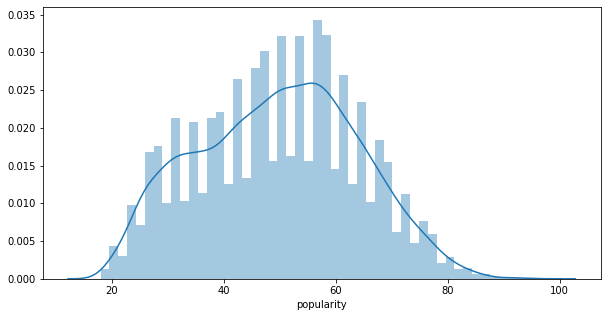

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['popularity']);

#### Gráfico que muestra las cantidades de tracks para cada una de las clases objetivo definidas

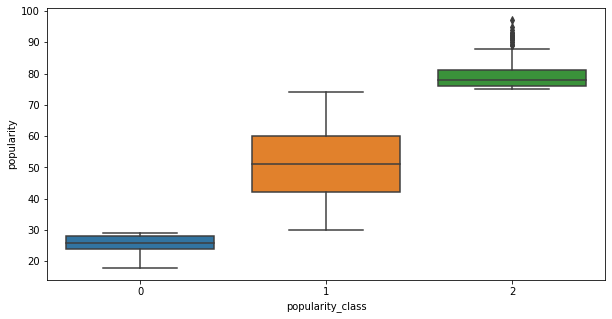

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='popularity_class', y='popularity', data=df)

# Entrenamiento de modelos <a id="entrenamiento"></a>

<a href="#titulo">Volver al índice</a>

In [18]:
training_cols = ['duration_ms', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'time_signature',
       'release_date_int', 'genre_ska', 'genre_flamenco', 'genre_metal',
       'genre_opera', 'genre_samba', 'genre_anime', 'genre_groove',
       'genre_indie', 'genre_bossa_nova', 'genre_trance', 'genre_rumba',
       'genre_gothic', 'genre_r&b', 'genre_under', 'genre_christian',
       'genre_folk', 'genre_reggae', 'genre_alternative', 'genre_rock',
       'genre_dubstep', 'genre_mambo', 'genre_dance', 'genre_country',
       'genre_funk', 'genre_reggaeton', 'genre_salsa', 'genre_swing',
       'genre_movie', 'genre_house', 'genre_freestyle', 'genre_instrumental',
       'genre_hip hop', 'genre_world', 'genre_blues', 'genre_neo',
       'genre_merengue', 'genre_disco', 'genre_punk', 'genre_bolero',
       'genre_jazz', 'genre_hardcore', 'genre_electronic', 'genre_trap',
       'genre_cumbia', 'genre_dub', 'genre_pop', 'genre_rave', 'genre_techno',
       'genre_ambient', 'genre_melodic', 'genre_progressive',
       'genre_experimental', 'genre_rap', 'genre_soul', 'genre_deep',
       'genre_tango', 'genre_others','escala_Do#', 'escala_Fa', 'escala_Fa#',
       'escala_La', 'escala_La#', 'escala_Mi', 'escala_Re', 'escala_Re#',
       'escala_Si', 'escala_Sol', 'escala_Sol#']

In [19]:
target_col = 'popularity_class'

In [20]:
X = df[training_cols]
y = df[target_col]

##### Vemos que las clases están desbalanceadas

In [21]:
classes_status = pd.Series(y).value_counts()

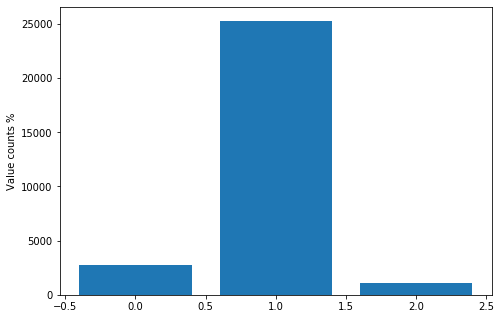

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts %')
plt.show()

##### Ya que la clase intermedia esta sobre representada, eliminamos algunos registros para que el entrenamiento de los modelos no consuma muchos recursos

In [23]:
percent_to_delete = .6
df_simplified = df.drop(df[df['popularity_class'] == 1].sample(frac=percent_to_delete).index)

In [24]:
X = df_simplified[training_cols]
y = df_simplified[target_col]

In [25]:
classes_status = pd.Series(y).value_counts()

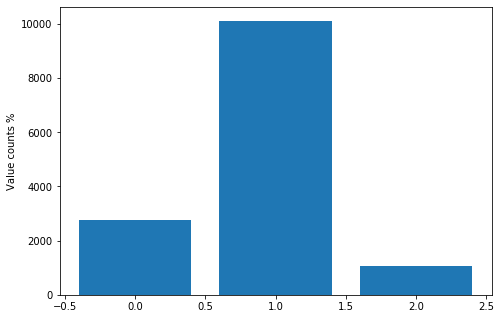

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts %')
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

##### Estandarizamos los features

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Oversampleamos las clases que tienen pocas ocurrencias

In [29]:
X_train_balanced_scaled, y_train_balanced  = SMOTE().fit_resample(X_train_scaled, y_train)

In [30]:
classes_status = pd.Series(y_train_balanced).value_counts()

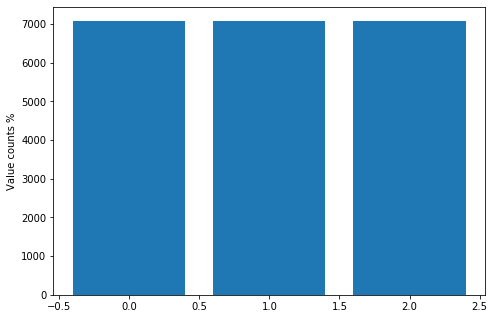

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts %')
plt.show()

## KNN  <a id="model_knn"></a>

In [33]:
start_time = time.time()
knn_scores = funcs.getScoresForHyperparameterK(quantityK=4, stepK= 1, model_X_train=X_train_balanced_scaled, \
                                               model_y_train=y_train_balanced, \
                                                kFold_N_Splits=5, KFold_shuffle=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 221.83242440223694 seconds ---


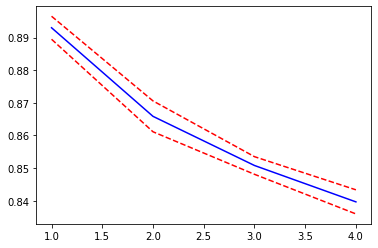

In [34]:
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_inferior'],color='r', linestyle='--')
plt.plot(knn_scores['n_neighbours'],knn_scores['score_medio'],color='b')
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_superior'],color='r', linestyle='--');

##### Mejor score

In [35]:
knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.893013,0.003525,1,0.889488,0.896539


##### Seleccionamos uno

In [36]:
best_k = knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 1


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [37]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
start_time = time.time()
knn_y_pred, knn_pred_score = funcs.getKNNPredictions(X_train_balanced_scaled, y_train_balanced, X_test, y_test, best_k)
print("--- %s seconds ---" % (time.time() - start_time))

KNeighborsClassifier(n_neighbors=1)
--- 8.175390720367432 seconds ---


##### Score KNN para el testeo

In [38]:
knn_pred_score

0.7252747252747253

##### Analizamos los resultados en la matriz de confusión

array([   0,  829,    0,    0, 3036,    0,    0,  321,    0], dtype=int64)

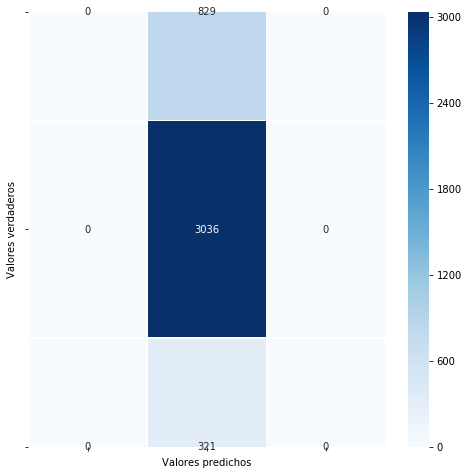

In [39]:
funcs.getConfusionMatrix(y_test, knn_y_pred, size= 8)

# Feature Selection <a id="feature_selection"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [42]:
start_time = time.time()
kf = KFold(n_splits=5, shuffle = True, random_state=42)
estimator = linear_model.LogisticRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selector.fit(X_train_balanced_scaled, y_train_balanced)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 fe

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


In [43]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % len(X_train.columns[selector.support_]))

Número original de features : 82
Número óptimo de features : 76


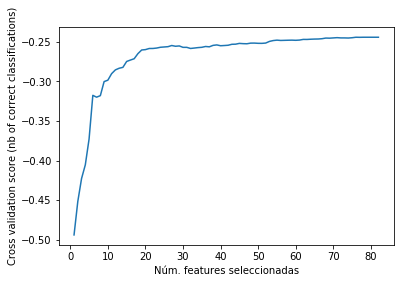

In [44]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [47]:
X = df_simplified[X_train.columns[selector.support_]]
y = df_simplified[target_col]

In [50]:
X_feature_selected_train, X_feature_selected_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

In [51]:
scaler = StandardScaler()
X_feature_selected_train_scaled = scaler.fit_transform(X_feature_selected_train)
X_feature_selected_test_scaled = scaler.transform(X_feature_selected_test)

##### Oversampleamos las clases que tienen pocas ocurrencias

In [52]:
start_time = time.time()
X_feature_selected_train_balanced_scaled, y_train_balanced  = SMOTE().fit_resample(X_feature_selected_train_scaled, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7355060577392578 seconds ---


In [53]:
classes_status = pd.Series(y_train_balanced).value_counts()

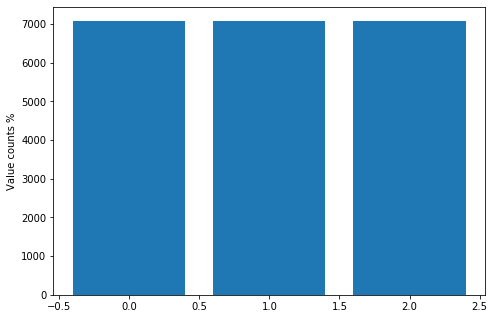

In [54]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts %')
plt.show()

## Feature Selection - KNN <a id="feature_selection_knn"></a>

<a href="#titulo">Volver al índice</a>

In [55]:
start_time = time.time()
knn_scores = funcs.getScoresForHyperparameterK(quantityK=4, stepK= 1, model_X_train=X_feature_selected_train_balanced_scaled, \
                                               model_y_train=y_train_balanced, \
                                                kFold_N_Splits=5, KFold_shuffle=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 208.0853419303894 seconds ---


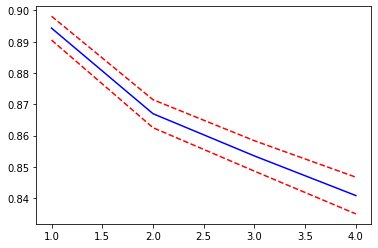

In [56]:
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_inferior'],color='r', linestyle='--')
plt.plot(knn_scores['n_neighbours'],knn_scores['score_medio'],color='b')
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_superior'],color='r', linestyle='--');

##### Mejor score

In [57]:
knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.894331,0.003806,1,0.890525,0.898137


##### Seleccionamos uno

In [58]:
best_k = knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 1


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [59]:
start_time = time.time()
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
knn_y_pred, knn_pred_score = funcs.getKNNPredictions(X_train_balanced_scaled, y_train_balanced, X_test, y_test, best_k)
print("--- %s seconds ---" % (time.time() - start_time))

KNeighborsClassifier(n_neighbors=1)
--- 8.693979501724243 seconds ---


##### Score KNN para el testeo

In [60]:
knn_pred_score

0.7252747252747253

##### Analizamos los resultados en la matriz de confusión

array([   0,  829,    0,    0, 3036,    0,    0,  321,    0], dtype=int64)

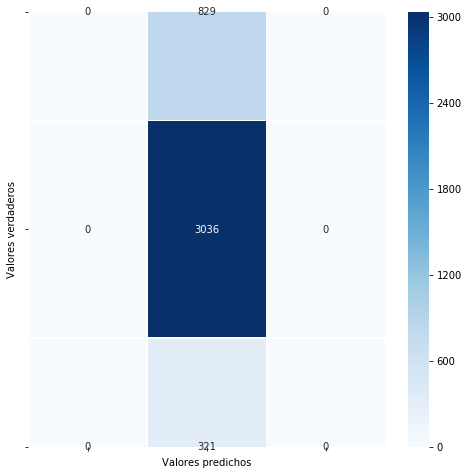

In [62]:
funcs.getConfusionMatrix(y_test, knn_y_pred, size= 8)

# Análisis de resultados <a id="results"></a>

<a href="#titulo">Volver al índice</a>